## Notebook for finding the best functions to contract an MPS into its wavefunction

In [1]:
import numpy as np
import ANNNIstates
from opt_einsum import contract
from typing import List, Union, Tuple, Optional
from jax import jit


In [2]:
# Variables
path = "../tensor_data"
L = 12
h = 0.5
kappa = 0.5
precision = 2

# Load the shapes and tensors array
shapes = np.loadtxt(
        f"{path}/shapes_sites_{'ANNNI'}_L_{L}_h_{h:.{precision}f}_kappa_{kappa:.{precision}f}"
    ).astype(int)

tensors = np.loadtxt(
        f"{path}/tensor_sites_{'ANNNI'}_L_{L}_h_{h:.{precision}f}_kappa_{kappa:.{precision}f}"
    )

In [3]:
# Load the list of MPS tensors
TT = ANNNIstates.state(shapes, tensors).MPS

### María/ncon implementation

In [4]:
## Support functions ##

def check_inputs(connect_list, flat_connect, dims_list, con_order):
  """ Check consistancy of NCON inputs"""

  pos_ind = flat_connect[flat_connect > 0]
  neg_ind = flat_connect[flat_connect < 0]

  # check that lengths of lists match
  if len(dims_list) != len(connect_list):
    raise ValueError(
        ('mismatch between %i tensors given but %i index sublists given') %
        (len(dims_list), len(connect_list)))

  # check that tensors have the right number of indices
  for ele in range(len(dims_list)):
    if len(dims_list[ele]) != len(connect_list[ele]):
      raise ValueError((
          'number of indices does not match number of labels on tensor %i: '
          '%i-indices versus %i-labels')
          % (ele, len(dims_list[ele]), len(connect_list[ele])))

  # check that contraction order is valid
  if not np.array_equal(np.sort(con_order), np.unique(pos_ind)):
    raise ValueError(('NCON error: invalid contraction order'))

  # check that negative indices are valid
  for ind in np.arange(-1, -len(neg_ind) - 1, -1):
    if sum(neg_ind == ind) == 0:
      raise ValueError(('NCON error: no index labelled %i') % (ind))
    elif sum(neg_ind == ind) > 1:
      raise ValueError(('NCON error: more than one index labelled %i') % (ind))

  # check that positive indices are valid and contracted tensor dimensions match
  flat_dims = np.array([item for sublist in dims_list for item in sublist])
  for ind in np.unique(pos_ind):
    if sum(pos_ind == ind) == 1:
      raise ValueError(('NCON error: only one index labelled %i') % (ind))
    elif sum(pos_ind == ind) > 2:
      raise ValueError(
          ('NCON error: more than two indices labelled %i') % (ind))

    cont_dims = flat_dims[flat_connect == ind]
    if cont_dims[0] != cont_dims[1]:
      raise ValueError(
          ('NCON error: tensor dimension mismatch on index labelled %i: '
           'dim-%i versus dim-%i') % (ind, cont_dims[0], cont_dims[1]))

  return True

def ncon(tensors: List[np.ndarray],
         connects: List[Union[List[int], Tuple[int]]],
         con_order: Optional[Union[List[int], str]] = None,
         check_network: Optional[bool] = True,
         which_env: Optional[int] = 0):
  """
  Network CONtractor: contracts a tensor network of N tensors via a sequence
  of (N-1) tensordot operations. More detailed instructions and examples can
  be found at: https://arxiv.org/abs/1402.0939.
  Args:
    tensors: list of the tensors in the network.
    connects: length-N list of lists (or tuples) specifying the network
      connections. The jth entry of the ith list in connects labels the edge
      connected to the jth index of the ith tensor. Labels should be positive
      integers for internal indices and negative integers for free indices.
    con_order: optional argument to specify the order for contracting the
      positive indices. Defaults to ascending order if omitted. Can also be
      set at "greedy" or "full" to call a solver to automatically determine
      the order.
    check_network: if true then the input network is checked for consistency;
      this can catch many common user mistakes for defining networks.
    which_env: if provided, ncon will produce the environment of the requested
      tensor (i.e. the network given by removing the specified tensor from
      the original network). Only valid for networks with no open indices.
  Returns:
    Union[np.ndarray,float]: the result of the network contraction; an
      np.ndarray if the network contained open indices, otherwise a scalar.
  """
  num_tensors = len(tensors)
  tensor_list = [tensors[ele] for ele in range(num_tensors)]
  connect_list = [np.array(connects[ele]) for ele in range(num_tensors)]

  # generate contraction order if necessary
  flat_connect = np.concatenate(connect_list)
  if con_order is None:
    con_order = np.unique(flat_connect[flat_connect > 0])
  else:
    con_order = np.array(con_order)

  # check inputs if enabled
  if check_network:
    dims_list = [list(tensor.shape) for tensor in tensor_list]
    check_inputs(connect_list, flat_connect, dims_list, con_order)

  # do all partial traces
  for ele in range(len(tensor_list)):
    num_cont = len(connect_list[ele]) - len(np.unique(connect_list[ele]))
    if num_cont > 0:
      tensor_list[ele], connect_list[ele], cont_ind = partial_trace(
          tensor_list[ele], connect_list[ele])
      con_order = np.delete(
          con_order,
          np.intersect1d(con_order, cont_ind, return_indices=True)[1])

  # do all binary contractions
  while len(con_order) > 0:
    # identify tensors to be contracted
    cont_ind = con_order[0]
    locs = [
        ele for ele in range(len(connect_list))
        if sum(connect_list[ele] == cont_ind) > 0
    ]

    # do binary contraction
    cont_many, A_cont, B_cont = np.intersect1d(
        connect_list[locs[0]],
        connect_list[locs[1]],
        assume_unique=True,
        return_indices=True)
    if np.size(tensor_list[locs[0]]) < np.size(tensor_list[locs[1]]):
      ind_order = np.argsort(A_cont)
    else:
      ind_order = np.argsort(B_cont)

    tensor_list.append(
        np.tensordot(
            tensor_list[locs[0]],
            tensor_list[locs[1]],
            axes=(A_cont[ind_order], B_cont[ind_order])))
    connect_list.append(
        np.append(
            np.delete(connect_list[locs[0]], A_cont),
            np.delete(connect_list[locs[1]], B_cont)))

    # remove contracted tensors from list and update con_order
    del tensor_list[locs[1]]
    del tensor_list[locs[0]]
    del connect_list[locs[1]]
    del connect_list[locs[0]]
    con_order = np.delete(
        con_order,
        np.intersect1d(con_order, cont_many, return_indices=True)[1])

  # do all outer products
  while len(tensor_list) > 1:
    s1 = tensor_list[-2].shape
    s2 = tensor_list[-1].shape
    tensor_list[-2] = np.outer(tensor_list[-2].reshape(np.prod(s1)),
                               tensor_list[-1].reshape(np.prod(s2))).reshape(
                                   np.append(s1, s2))
    connect_list[-2] = np.append(connect_list[-2], connect_list[-1])
    del tensor_list[-1]
    del connect_list[-1]

  # do final permutation
  if len(connect_list[0]) > 0:
    return np.transpose(tensor_list[0], np.argsort(-connect_list[0]))
  else:
    return tensor_list[0].item()

In [22]:
def ncon_contraction(tensors, d = 2):
    L = len(tensors)
    contraction = tensors[0]
    for i in range(L - 1):
        contraction = ncon([contraction, tensors[i + 1]],[[-1,-2,1],[1,-3,-4]]).reshape(contraction.shape[0], d ** (i + 2), tensors[i + 1].shape[2])
    return contraction[0].flatten()

### opt_einsum implementation (CPU)

In [23]:
# Real ugly workaround, forget you are reading this

allchars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

def get_subscript(L):
    """ 
    This function returns the correct subscript for the opt_einsum MPS contraction
    """ 
    subscript = '' 
    for l in range(L):
         subscript += allchars[2*l:2*l+3]+','

    return subscript[:-1]

# Also it works up to 26, but I do not think we want to access a 2^26 dimensional vector

In [24]:
def einsum_contraction(tensors): 
    return contract(get_subscript(len(tensors)), *tensors).flatten()

### opt_einsum implementation (GPU)

In [25]:
@jit
def einsum_contraction_GPU(tensors): 
    return contract(get_subscript(len(tensors)), *tensors, backend='jax').flatten()

### Do the three methods output the same results?

In [26]:
# Load different tensors to avoid weird cache behaviour during the time evaluation
h2    = 0.5
kappa2 = 0.5

shapes2 = np.loadtxt(f"{path}/shapes_sites_{'ANNNI'}_L_{L}_h_{h2:.{precision}f}_kappa_{kappa2:.{precision}f}").astype(int)
tensors2 = np.loadtxt(f"{path}/tensor_sites_{'ANNNI'}_L_{L}_h_{h2:.{precision}f}_kappa_{kappa2:.{precision}f}")
TT2 = ANNNIstates.state(shapes2, tensors2).MPS

w1 = ncon_contraction(TT2)
w2 = einsum_contraction(TT2)
w3 = einsum_contraction_GPU(TT2)


if (np.isclose(w1,w2).all() and np.isclose(w2,w3).all()):
    print('Results are consistent')
else:
    print('Results are NOT consistent')

Results are consistent


## Benchmarking

In [27]:
print('NCON:')
ncon_time      = %timeit -o ncon_contraction(TT)

NCON:
2.4 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
print('opt_einsum:')
einsumcpu_time = %timeit -o einsum_contraction(TT)

opt_einsum:
1.74 ms ± 915 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
print('opt_einsum + jit + jax backend:')
einsumgpu_time = %timeit -o einsum_contraction_GPU(TT)

opt_einsum + jit + jax backend:
514 µs ± 127 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


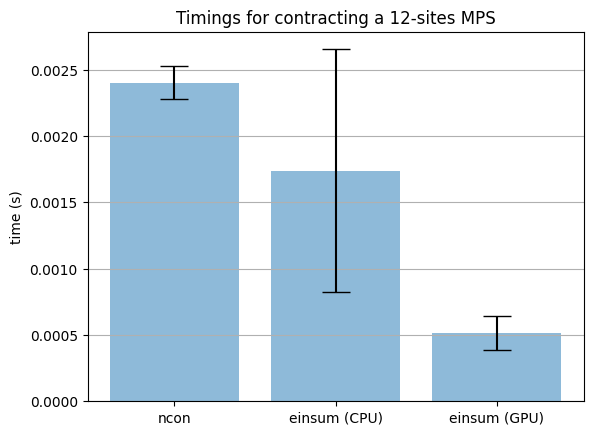

In [35]:
import matplotlib.pyplot as plt

averages = [time.average for time in [ncon_time, einsumcpu_time, einsumgpu_time]]
stevs    = [time.stdev   for time in [ncon_time, einsumcpu_time, einsumgpu_time]]
x_pos    = np.arange(len(averages))
labels   = ['ncon', 'einsum (CPU)', 'einsum (GPU)']
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, averages, yerr=stevs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('time (s)')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title(f'Timings for contracting a {L}-sites MPS')
ax.yaxis.grid(True)